<a href="https://colab.research.google.com/github/Gantcho/CSE547-Basketball_Stats/blob/main/Copy2_of_CSE547_FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd

# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

**Basketball Player Performance Prediction**\
Loading data set

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

def minToFloat(min): #mins are stored in fromat 12:23:14, need to fix that!
  if min is None or min == "":
    return 0
  index = min.find(':')
  if index == 0:
    return 0
  try:
    if index == -1 or index==len(min)-1: #for weird cases like no ":" or "12:"
      return float(min[0:index])
  
    return float(min[0:index])+float(min[index+1:index+3])/60
  except: #I know this is bad but for now there is some weird games that have poorly recorded mins which we will ignore
    return 0
  

minUDF = udf(lambda x: minToFloat(x),DoubleType()) 

#gd=spark.read.format("csv").option("header","true").option("inferSchema", True).load("games_details.csv")
gd=spark.read.format("csv").option("header","true").option("inferSchema", True).load("drive/MyDrive/CSE547/games_details.csv")
gd = gd.withColumn("MIN_Double", minUDF(col("MIN"))).drop("MIN").withColumnRenamed("MIN_Double","MIN")
games_seasons=spark.read.format("csv").option("header","true").option("inferSchema", True).\
                load("drive/MyDrive/CSE547/games.csv").select(["GAME_ID","SEASON"])
gd = gd.join(games_seasons, ["GAME_ID"])
gd.printSchema()

root
 |-- GAME_ID: integer (nullable = true)
 |-- TEAM_ID: integer (nullable = true)
 |-- TEAM_ABBREVIATION: string (nullable = true)
 |-- TEAM_CITY: string (nullable = true)
 |-- PLAYER_ID: integer (nullable = true)
 |-- PLAYER_NAME: string (nullable = true)
 |-- NICKNAME: string (nullable = true)
 |-- START_POSITION: string (nullable = true)
 |-- COMMENT: string (nullable = true)
 |-- FGM: double (nullable = true)
 |-- FGA: double (nullable = true)
 |-- FG_PCT: double (nullable = true)
 |-- FG3M: double (nullable = true)
 |-- FG3A: double (nullable = true)
 |-- FG3_PCT: double (nullable = true)
 |-- FTM: double (nullable = true)
 |-- FTA: double (nullable = true)
 |-- FT_PCT: double (nullable = true)
 |-- OREB: double (nullable = true)
 |-- DREB: double (nullable = true)
 |-- REB: double (nullable = true)
 |-- AST: double (nullable = true)
 |-- STL: double (nullable = true)
 |-- BLK: double (nullable = true)
 |-- TO: double (nullable = true)
 |-- PF: double (nullable = true)
 |-- PTS

In [ ]:
#from pyspark.ml.feature import VectorAssembler
#import pyspark.sql.functions as F
#totalplayercount = gd.groupBy("PLAYER_ID","PLAYER_NAME").agg(F.sum("MIN")).count()
#print(f"total player {totalplayercount}")

In [ ]:
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F

gd_reduced=gd.filter(gd.COMMENT.isNull()).filter(gd.MIN > 400)
              # All comments relate to why a player didn't play, so no stats recorded
              # Dropping players with less than 48 minutes (one games worth total over there whole career)
gd_sums = gd_reduced.groupBy("PLAYER_ID","PLAYER_NAME","SEASON")\
   .agg(F.sum("MIN").alias("MIN"),
        F.sum("FGA").alias("FGA"),
        F.sum("FGM").alias("FGM"),
        F.sum("FG3A").alias("FG3A"),
        F.sum("FG3M").alias("FG3M"),
        F.sum("FTA").alias("FTA"),
        F.sum("FTM").alias("FTM"),
        F.sum("OREB").alias("OREB"),
        F.sum("DREB").alias("DREB"),
        F.sum("REB").alias("REB"),
        F.sum("AST").alias("AST"),
        F.sum("STL").alias("STL"),
        F.sum("BLK").alias("BLK"),
        F.sum("TO").alias("TO"),
        F.sum("PF").alias("PF"),
        F.sum("PTS").alias("PTS"),
        F.sum("PLUS_MINUS").alias("PLUS_MINUS"),#Plus Minus is exluded because that's just the quality of player, not really their playstyle
        )



In [ ]:
#This is just to see if we can remove some players who never really play
import matplotlib.pyplot as plt
minutes = [0,1,5,10,20,48,100,200,500,1000]
players = []
for i in minutes:
  print(i)
  players.append(gd_sums.filter(gd_sums.MIN > i).count())
plt.plot(minutes,players)
plt.xlabel("Minutes Played")
plt.ylabel("Number of Players")
plt.title("Num Players that Played at Least X Minutes")
plt.savefig("PlayerCounts")


In [ ]:
gd_sums = gd_sums.filter(gd_sums.MIN > 400)#Change this to however many minutes you want!
gd_avgs = gd_sums.withColumn("MFGA", 
                 (F.col("FGA") / F.col("MIN"))).withColumn("FGPCT", 

                 (F.col("FGM") / F.col("FGA"))).withColumn("MFG3A",  #total percent
                 (F.col("FG3A") / F.col("MIN"))).withColumn("FG3PCT", 
                 (F.col("FG3M") / F.col("FG3A"))).withColumn("MFTA", 
                 (F.col("FTA") / F.col("MIN"))).withColumn("FTPCT", 
                 (F.col("FTM") / F.col("FTA"))).withColumn("MOREB", 
                 (F.col("OREB") / F.col("MIN"))).withColumn("MDREB", 
                 (F.col("DREB") / F.col("MIN"))).withColumn("MREB", 
                 (F.col("REB") / F.col("MIN"))).withColumn("MAST",  #If a player gets lots of rebounds, but is evenly split between
                                                #OREB and DREB, they are still similar to a player with only DREB
                 (F.col("AST") / F.col("MIN"))).withColumn("MSTL", 
                 (F.col("STL") / F.col("MIN"))).withColumn("MBLK", 
                 (F.col("BLK") / F.col("MIN"))).withColumn("MTO", 
                 (F.col("TO") / F.col("MIN"))).withColumn("MPF", 
                 (F.col("PF") / F.col("MIN"))).withColumn("MPTS", 
                 (F.col("PTS") / F.col("MIN"))).withColumn("MPLUSMIN", 
                 (F.col("PLUS_MINUS") / F.col("MIN"))).na.fill(value=0.0)#the fill statement reokaces all null values wit hzero
                                                              #This handles people with no attempted threes, etc.
                                                              #Might be an issue! maybe better to set it to something else

                 #Plus Minus cam maybe be exluded because that's just the quality of player, not really their playstyle



In [ ]:
columnlist = ["FGPCT",
"MFG3A",
"FG3PCT",
"MFTA",
"FTPCT",
"MOREB",
"MDREB",
"MREB",
"MAST",
"MSTL",
"MBLK",
"MTO",
"MPF",
"MPTS",
"MPLUSMIN"]
meanlist = [gd_avgs.select(mean(c)).first()[0] for c in columnlist]
stddevlist = [gd_avgs.select(stddev(c)).first()[0] for c in columnlist]
meandict={}
stddevdict ={}
for index, colname in enumerate(columnlist):
  meandict[colname] = meanlist[index]
  stddevdict[colname] = stddevlist[index]


gd_normal = gd_avgs.select(['PLAYER_ID', 'SEASON']+[udf(lambda x : (x - meandict[c])/stddevdict[c], DoubleType())(col(c)) for c in columnlist])

#type(column)

In [ ]:
assemble=VectorAssembler(inputCols=["<lambda>(FGPCT)", 
                "<lambda>(MFG3A)", 
                 "<lambda>(FG3PCT)", 
                  "<lambda>(MFTA)", 
                 "<lambda>(FTPCT)", 
                 "<lambda>(MOREB)", 
                 "<lambda>(MDREB)", 
                 "<lambda>(MREB)", 
                 "<lambda>(MAST)",  
                  "<lambda>(MSTL)", 
                 "<lambda>(MBLK)", 
                 "<lambda>(MTO)", 
                 "<lambda>(MPF)", 
                 "<lambda>(MPTS)", 
                 "<lambda>(MPLUSMIN)"
],outputCol = 'avg_features')

assembled_data=assemble.transform(gd_normal) 

In [ ]:
add_year_to_id = udf(lambda a, b: f"{a}_{b}", StringType())

assembled_data = assembled_data.withColumn("PLAYER_ID", add_year_to_id(col("PLAYER_ID"), col("SEASON")))

In [ ]:
assembled_data.show(4)

+------------+------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+
|   PLAYER_ID|SEASON|    <lambda>(FGPCT)|     <lambda>(MFG3A)|   <lambda>(FG3PCT)|     <lambda>(MFTA)|     <lambda>(FTPCT)|     <lambda>(MOREB)|    <lambda>(MDREB)|      <lambda>(MREB)|     <lambda>(MAST)|      <lambda>(MSTL)|      <lambda>(MBLK)|      <lambda>(MTO)|       <lambda>(MPF)|     <lambda>(MPTS)|  <lambda>(MPLUSMIN)|        avg_features|
+------------+------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+----------

START OF ATTEMPTING TO CREATE PER GAME DATASET AND TRAIN/TEST SETS 

In [ ]:
# Drop unneeded columns
cols_to_drop = ("TEAM_ABBREVIATION", "TEAM_CITY", "PLAYER_NAME", "NICKNAME", "START_POSITION", "COMMENT")
per_game_data = gd_reduced.drop(*cols_to_drop)

In [ ]:
per_game_data = per_game_data.withColumn("PLAYER_ID", add_year_to_id(col("PLAYER_ID"), col("SEASON")))

In [ ]:
# Order by minutes played and then group per game and by team
pg_data = per_game_data.orderBy(desc("MIN")).groupBy("GAME_ID", "TEAM_ID")\
                          .agg(F.collect_list("PLAYER_ID").alias("PLAYER_IDS"),
                               F.collect_list("FGM").alias("FGM"),
                               F.collect_list("FGA").alias("FGA"),
                               F.collect_list("FG_PCT").alias("FG_PCT"),
                               F.collect_list("FG3M").alias("FG3M"),
                               F.collect_list("FG3A").alias("FG3A"),
                               F.collect_list("FG3_PCT").alias("FG3_PCT"),
                               F.collect_list("FTM").alias("FTM"),
                               F.collect_list("FTA").alias("FTA"),
                               F.collect_list("FT_PCT").alias("FT_PCT"),
                               F.collect_list("OREB").alias("OREB"),
                               F.collect_list("DREB").alias("DREB"),
                               F.collect_list("REB").alias("REB"),
                               F.collect_list("AST").alias("AST"),
                               F.collect_list("STL").alias("STL"),
                               F.collect_list("BLK").alias("BLK"),
                               F.collect_list("TO").alias("TO"),
                               F.collect_list("PF").alias("PF"),
                               F.collect_list("PTS").alias("PTS"),
                               F.collect_list("PLUS_MINUS").alias("PLUS_MINUS"),
                               F.collect_list("MIN").alias("MIN"),
                               F.collect_set("SEASON").alias("SEASON"))

In [ ]:
from pyspark.sql.types import *

# I assume starters are the 5 that play the most minutes (THIS IS LIKELY NOT A VALID ASSUMPTION)
get_starters = udf(lambda x: x[:5], ArrayType(StringType()))
pg_data = pg_data.withColumn("PLAYER_IDS", get_starters(pg_data["PLAYER_IDS"]))

In [ ]:
# Combine by game to get lists of both sets of starters and their stats
pg_data=pg_data.groupBy("GAME_ID").agg(F.collect_list("PLAYER_IDS").alias("PLAYER_IDS"),
                                    F.collect_list("PTS").alias("PTS"))

In [ ]:
from functools import reduce
# Reduce player ids to be 1 list instead of a nested list
combine_lists_str = udf(lambda x: reduce(lambda a,b: a+b, x), ArrayType(StringType()))
combine_lists_dbl = udf(lambda x: reduce(lambda a,b: a+b, x), ArrayType(DoubleType()))
pg_data = pg_data.withColumn("PLAYER_IDS", combine_lists_str(col("PLAYER_IDS")))
pg_data = pg_data.withColumn("PTS", combine_lists_dbl(col("PTS")))

In [ ]:
from pyspark.ml.functions import vector_to_array
assembled_data = assembled_data.withColumn("avg_features", vector_to_array(col("avg_features")))

In [ ]:
pg_data.take(4)

[Row(GAME_ID=10500002, PLAYER_IDS=['947_2005', '2738_2005', '101184_2005', '2422_2005', '2594_2005', '133_2005', '1507_2005', '436_2005', '2437_2005', '983_2005'], PTS=[23.0, 16.0, 1.0, 9.0, 10.0, 7.0, 2.0, 7.0, 8.0, 4.0, 4.0, 3.0, 13.0, 10.0, 8.0, 9.0, 7.0, 15.0, 19.0, 2.0, 5.0, 13.0]),
 Row(GAME_ID=10500003, PLAYER_IDS=['2052_2005', '2730_2005', '255_2005', '2045_2005', '2435_2005', '1733_2005', '2207_2005', '2746_2005', '2735_2005', '101107_2005'], PTS=[15.0, 15.0, 12.0, 10.0, 14.0, 6.0, 12.0, 6.0, 10.0, 2.0, 7.0, 18.0, 13.0, 9.0, 12.0, 7.0, 18.0, 1.0, 4.0]),
 Row(GAME_ID=10500004, PLAYER_IDS=['2552_2005', '101188_2005', '2457_2005', '2736_2005', '2450_2005', '686_2005', '2306_2005', '2568_2005', '2545_2005', '2230_2005'], PTS=[17.0, 4.0, 11.0, 8.0, 1.0, 8.0, 5.0, 2.0, 2.0, 6.0, 4.0, 4.0, 8.0, 6.0, 7.0, 12.0, 15.0, 9.0, 4.0, 11.0, 7.0, 4.0]),
 Row(GAME_ID=10500005, PLAYER_IDS=['1719_2005', '1802_2005', '101128_2005', '2078_2005', '1903_2005', '2734_2005', '2205_2005', '1717_2005', '

In [ ]:
assembled_data.printSchema()

root
 |-- PLAYER_ID: string (nullable = true)
 |-- SEASON: integer (nullable = true)
 |-- <lambda>(FGPCT): double (nullable = true)
 |-- <lambda>(MFG3A): double (nullable = true)
 |-- <lambda>(FG3PCT): double (nullable = true)
 |-- <lambda>(MFTA): double (nullable = true)
 |-- <lambda>(FTPCT): double (nullable = true)
 |-- <lambda>(MOREB): double (nullable = true)
 |-- <lambda>(MDREB): double (nullable = true)
 |-- <lambda>(MREB): double (nullable = true)
 |-- <lambda>(MAST): double (nullable = true)
 |-- <lambda>(MSTL): double (nullable = true)
 |-- <lambda>(MBLK): double (nullable = true)
 |-- <lambda>(MTO): double (nullable = true)
 |-- <lambda>(MPF): double (nullable = true)
 |-- <lambda>(MPTS): double (nullable = true)
 |-- <lambda>(MPLUSMIN): double (nullable = true)
 |-- avg_features: array (nullable = false)
 |    |-- element: double (containsNull = false)



PANDAS DETOUR. I GOT UPSET WITH SPARK AND AM TRYING TO REWORK IT ALL IN PANDAS. YOU CAN SKIP THESE IF YOU JUST WANT TO TRY TO USE SPARK

In [ ]:
temp = assembled_data.select('PLAYER_ID', 'avg_features')

In [ ]:
player_data_pd = temp.toPandas()

In [ ]:
player_data_pd.head()

,PLAYER_ID,avg_features


In [ ]:
game_data_pd = pg_data.toPandas()

In [ ]:
game_data_pd.head()

,GAME_ID,PLAYER_IDS,PTS


In [ ]:
print("101184_2005" in player_data_pd['PLAYER_ID'].values)

False


In [ ]:
# Quick check to see if every player ID in game_data_pd is actually in player_data_pd. I have my suspicions that they are not all in there.
players_list = player_data_pd['PLAYER_ID'].tolist()
for idx, player_ids in enumerate(game_data_pd['PLAYER_IDS'].tolist()):
  if len(player_ids) != 10:
    print(f"THERE ARE NOT 10 PLAYERS IN GAME: {idx}")
  for player_id in player_ids:
    if player_id not in players_list:
      print(f"PLAYER {player_id} NOT IN PLAYER_PD_DATA")
print("DONE")

PLAYER 101184_2005 NOT IN PLAYER_PD_DATA
PLAYER 2435_2005 NOT IN PLAYER_PD_DATA
PLAYER 101188_2005 NOT IN PLAYER_PD_DATA
PLAYER 2450_2005 NOT IN PLAYER_PD_DATA
PLAYER 243_2005 NOT IN PLAYER_PD_DATA
PLAYER 101215_2005 NOT IN PLAYER_PD_DATA
PLAYER 101223_2005 NOT IN PLAYER_PD_DATA
PLAYER 468_2005 NOT IN PLAYER_PD_DATA
PLAYER 101185_2005 NOT IN PLAYER_PD_DATA
PLAYER 2788_2005 NOT IN PLAYER_PD_DATA
PLAYER 955_2005 NOT IN PLAYER_PD_DATA
PLAYER 101156_2005 NOT IN PLAYER_PD_DATA
PLAYER 2682_2005 NOT IN PLAYER_PD_DATA
PLAYER 101120_2005 NOT IN PLAYER_PD_DATA
PLAYER 101217_2005 NOT IN PLAYER_PD_DATA
PLAYER 2697_2005 NOT IN PLAYER_PD_DATA
PLAYER 101152_2005 NOT IN PLAYER_PD_DATA
PLAYER 2401_2005 NOT IN PLAYER_PD_DATA
PLAYER 2499_2005 NOT IN PLAYER_PD_DATA
PLAYER 2245_2005 NOT IN PLAYER_PD_DATA
PLAYER 2109_2005 NOT IN PLAYER_PD_DATA
PLAYER 2637_2005 NOT IN PLAYER_PD_DATA
PLAYER 101223_2005 NOT IN PLAYER_PD_DATA
PLAYER 2499_2005 NOT IN PLAYER_PD_DATA
PLAYER 2637_2005 NOT IN PLAYER_PD_DATA
PLAYER 4

KeyboardInterrupt: ignored

In [ ]:
import numpy as np

features_col = []
for ids in game_data_pd['PLAYER_IDS']:
  avg_feats = []
  for id in ids:
    try:
      avg_feats.append(player_data_pd.loc[player_data_pd['PLAYER_ID'] == id, 'avg_features'].item())
    except:
      avg_feats.append(np.zeros(15))
  features_col.append(avg_feats)

game_data_pd['avg_features_list'] = features_col

In [ ]:
game_data_pd.head()

,GAME_ID,PLAYER_IDS,PTS,avg_features_list
0,10500002,"[947_2005, 2738_2005, 101184_2005, 2422_2005, ...","[23.0, 16.0, 1.0, 9.0, 10.0, 7.0, 2.0, 7.0, 8....","[[-0.06321305940480013, -0.2613923596508858, 0..."
1,10500003,"[2052_2005, 2730_2005, 255_2005, 2045_2005, 24...","[15.0, 15.0, 12.0, 10.0, 14.0, 6.0, 12.0, 6.0,...","[[0.09299467548016109, -1.2122539565083776, -1..."
2,10500004,"[2552_2005, 101188_2005, 2457_2005, 2736_2005,...","[17.0, 4.0, 11.0, 8.0, 1.0, 8.0, 5.0, 2.0, 2.0...","[[-0.04763891760643914, -1.303336477806775, -1..."
3,10500005,"[1719_2005, 1802_2005, 101128_2005, 2078_2005,...","[6.0, 12.0, 9.0, 6.0, 10.0, 5.0, 8.0, 5.0, 11....","[[0.4064368043321808, -0.902497077197132, -0.0..."
4,10500006,"[2211_2005, 2740_2005, 1884_2005, 965_2005, 22...","[8.0, 1.0, 17.0, 8.0, 14.0, 13.0, 6.0, 9.0, 2....","[[-0.4398733997693921, -0.25488995872318, 0.26..."


In [ ]:
game_data_pd = copy.copy()
game_data_pd.head()

,GAME_ID,PLAYER_IDS,PTS,avg_features_list
0,10500002,"[947_2005, 2738_2005, 101184_2005, 2422_2005, ...","[23.0, 16.0, 1.0, 9.0, 10.0, 7.0, 2.0, 7.0, 8....","[[-0.06321305940480013, -0.2613923596508858, 0..."
1,10500003,"[2052_2005, 2730_2005, 255_2005, 2045_2005, 24...","[15.0, 15.0, 12.0, 10.0, 14.0, 6.0, 12.0, 6.0,...","[[0.09299467548016109, -1.2122539565083776, -1..."
2,10500004,"[2552_2005, 101188_2005, 2457_2005, 2736_2005,...","[17.0, 4.0, 11.0, 8.0, 1.0, 8.0, 5.0, 2.0, 2.0...","[[-0.04763891760643914, -1.303336477806775, -1..."
3,10500005,"[1719_2005, 1802_2005, 101128_2005, 2078_2005,...","[6.0, 12.0, 9.0, 6.0, 10.0, 5.0, 8.0, 5.0, 11....","[[0.4064368043321808, -0.902497077197132, -0.0..."
4,10500006,"[2211_2005, 2740_2005, 1884_2005, 965_2005, 22...","[8.0, 1.0, 17.0, 8.0, 14.0, 13.0, 6.0, 9.0, 2....","[[-0.4398733997693921, -0.25488995872318, 0.26..."


In [ ]:
from functools import reduce
game_data_pd['avg_features_list'] = game_data_pd.apply(lambda x: reduce(lambda a,b: a+b, x[2]), axis=1)
game_data_pd.head()

,GAME_ID,PLAYER_IDS,PTS,avg_features_list
0,10500002,"[947_2005, 2738_2005, 101184_2005, 2422_2005, ...","[23.0, 16.0, 1.0, 9.0, 10.0, 7.0, 2.0, 7.0, 8....",195.0
1,10500003,"[2052_2005, 2730_2005, 255_2005, 2045_2005, 24...","[15.0, 15.0, 12.0, 10.0, 14.0, 6.0, 12.0, 6.0,...",191.0
2,10500004,"[2552_2005, 101188_2005, 2457_2005, 2736_2005,...","[17.0, 4.0, 11.0, 8.0, 1.0, 8.0, 5.0, 2.0, 2.0...",155.0
3,10500005,"[1719_2005, 1802_2005, 101128_2005, 2078_2005,...","[6.0, 12.0, 9.0, 6.0, 10.0, 5.0, 8.0, 5.0, 11....",173.0
4,10500006,"[2211_2005, 2740_2005, 1884_2005, 965_2005, 22...","[8.0, 1.0, 17.0, 8.0, 14.0, 13.0, 6.0, 9.0, 2....",185.0


In [ ]:
x=copy['avg_features_list'][0]
print(x)

[[-0.06321305940480013, -0.2613923596508858, 0.2326790827891209, 3.7021162915082106, 0.600462810544607, -0.9484265639174714, -1.3642119100844359, -1.2881597518109664, 1.5366913058183604, 1.2889109565855497, -0.914128600513515, 1.212259341060045, -1.6837851115232787, 3.1323022820881836, 0.1364897796964157, [0.68112208083622, -0.5617760692487526, 0.4342766063388117, 0.5356284393356752, 0.03502032261803784, -0.21655612229614435, -0.16212087719446241, -0.19734406530726475, 0.01878684319168814, 1.4369606966249255, -0.6831842998918091, -0.19197205300369657, -0.8375447947758078, -0.49205413103877405, 0.13928093829507912]], [0.68112208083622, -0.5617760692487526, 0.4342766063388117, 0.5356284393356752, 0.03502032261803784, -0.21655612229614435, -0.16212087719446241, -0.19734406530726475, 0.01878684319168814, 1.4369606966249255, -0.6831842998918091, -0.19197205300369657, -0.8375447947758078, -0.49205413103877405, 0.13928093829507912], array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
y = reduce(lambda a,b: a+b, x)
print(y)

<ipython-input-63-bf46b40b4882>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = reduce(lambda a,b: a+b, x)


ValueError: ignored

In [ ]:
y

[1, 2, 3, 4]

END OF PANDAS DETOUR

This is the key step that I cannot figure out. We have two spark dataframes pg_data and assembled_data. In assembled_data we have a column corresponding to PLAYER_ID and a column called avg_features which contains a vector of their average statistics. In pg_data we have a column called PLAYER_IDS which is an array of ids. We need to find a way to add a column to pg_data which is a 2D array corresponding to a list of avg_features vectors for every id in PLAYER_IDS. This is the per-game feature that we will train on. 

The two commented out cells below are both failed attempts.

In [ ]:
# Create a dataframe which has all of the avg_features of all players in PLAYER_IDS
#joined_df = pg_data.join(assembled_data, F.array_contains(pg_data["PLAYER_IDS"], assembled_data["PLAYER_ID"]), "left")
#result_df = joined_df.groupby("PLAYER_IDS").agg(F.collect_list("avg_features").alias("avg_features_list"),
#                                                F.collect_set("GAME_ID").alias("GAME_ID"))

In [ ]:
# Failed attempt at fixing issues
'''def get_avg_features_list(player_ids):
  fl = []
  for player_id in player_ids:
    fl.append(assembled_data.select('avg_features').where(col('PLAYER_ID')==player_id).collect())

get_avg_features_list_udf = udf(lambda x: get_avg_features_list(x), ArrayType(ArrayType(DoubleType())))
result_df = pg_data.withColumn("avg_features_list", get_avg_features_list_udf(col("PLAYER_IDS")))'''

In [ ]:
pg_data.printSchema()

root
 |-- GAME_ID: integer (nullable = true)
 |-- PLAYER_IDS: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- PTS: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [ ]:
# Extract GAME_ID from a list
get_id = udf(lambda x: x[0], IntegerType())
result_df = result_df.withColumn("GAME_ID", get_id("GAME_ID"))
result_df.take(1)

[Row(PLAYER_IDS=['1000_2003', '1496_2003', '970_2003', '950_2003', '358_2003', '714_2003', '952_2003', '1717_2003', '959_2003', '2572_2003'], avg_features_list=[[0.6651191617111709, -1.303336477806775, -1.9095624675394014, -0.11645326207692785, -0.038444521363808264, 0.5473478559069356, 0.019699443032797262, 0.24605270506666177, -0.9807890430777714, -1.5325199019138436, -0.2573718451884101, 0.835244402276685, 1.811967012889666, -0.9507843216887754, -0.44400616566890533], [-0.41280567226848663, -0.14994203725961927, 0.2392944903693515, 0.7898209106071093, 0.5840146556277166, -0.8362485624009086, -1.3647712316650054, -1.240710042228566, 2.2474067370007913, 0.6496364710038772, -0.9442136961269953, 0.936914632139992, -1.2960331401633975, 0.7190429503466894, -0.19371825880892754], [-0.5889843238744679, -0.7323851992010018, 0.0996822482153524, -0.12651219078124187, -0.28040361895714644, 1.483450482998063, 0.08071017839253486, 0.6845662634129264, -0.5056733666718949, 1.0856891416647414, 0.753

In [ ]:
# Merge 2d list of avg_features into one large vector that becomes our game feature
final_data = result_df.withColumn("avg_features_list", combine_lists_dbl(col("avg_features_list")))
final_data = final_data.orderBy("GAME_ID")
final_data.show(10)

+--------------------+--------------------+--------+
|          PLAYER_IDS|   avg_features_list| GAME_ID|
+--------------------+--------------------+--------+
|[2400_2005, 1716_...|[-0.0903760496180...|10500001|
|[947_2005, 2738_2...|[-0.9719664542779...|10500002|
|[2052_2005, 2730_...|[1.25244957482303...|10500003|
|[2552_2005, 10118...|[0.21761992302005...|10500004|
|[1719_2005, 1802_...|[0.18028521566597...|10500005|
|[2211_2005, 2740_...|[0.77716402109465...|10500006|
|[1531_2005, 2210_...|[0.68033819965522...|10500007|
|[1800_2005, 923_2...|[-1.1096377378595...|10500008|
|[101261_2005, 101...|[-0.4980059428534...|10500009|
|[2732_2005, 1983_...|[2.40682156805261...|10500010|
+--------------------+--------------------+--------+
only showing top 10 rows



In [ ]:
pg_data = pg_data.orderBy("GAME_ID")
pg_data.show(10)

+--------+--------------------+--------------------+
| GAME_ID|          PLAYER_IDS|                 PTS|
+--------+--------------------+--------------------+
|10500001|[2400_2005, 1716_...|[16.0, 9.0, 16.0,...|
|10500002|[947_2005, 2738_2...|[23.0, 16.0, 1.0,...|
|10500003|[2052_2005, 2730_...|[15.0, 15.0, 12.0...|
|10500004|[2552_2005, 10118...|[17.0, 4.0, 11.0,...|
|10500005|[1719_2005, 1802_...|[6.0, 12.0, 9.0, ...|
|10500006|[2211_2005, 2740_...|[8.0, 1.0, 17.0, ...|
|10500007|[1531_2005, 2210_...|[11.0, 8.0, 4.0, ...|
|10500008|[1800_2005, 923_2...|[6.0, 13.0, 11.0,...|
|10500009|[101261_2005, 101...|[13.0, 4.0, 5.0, ...|
|10500010|[2732_2005, 1983_...|[9.0, 10.0, 2.0, ...|
+--------+--------------------+--------------------+
only showing top 10 rows



START OF MODEL TRAINING. IF YOU GET TO THIS POINT AND THINK ITS CORRECT YOU ARE A BETTER CODER THAN ME!!!!!!!

In [ ]:
X_data = final_data.toPandas()
y_data = pg_data.toPandas()

In [ ]:
X = X_data["avg_features_list"]
y = y_data["PTS"]

In [ ]:
X=np.array(X)
y=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2)

In [ ]:
len(X[9])

105

In [ ]:
np.vstack(X.values).shape

ValueError: ignored

In [ ]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
import numpy as np

xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

ValueError: ignored

END

2
evaluation score : 0.4469544981477053
3
evaluation score : 0.3142509065564026
4
evaluation score : 0.33805841863551844
5
evaluation score : 0.3161458452963727
6
evaluation score : 0.28748941105269
7
evaluation score : 0.27799592072745033
8
evaluation score : 0.2861148002431525
9
evaluation score : 0.2677905221302704
10
evaluation score : 0.27801280054572164
11
evaluation score : 0.2607593633890746
12
evaluation score : 0.23506312467987728
13
evaluation score : 0.20239232591536344
14
evaluation score : 0.2476097897450461


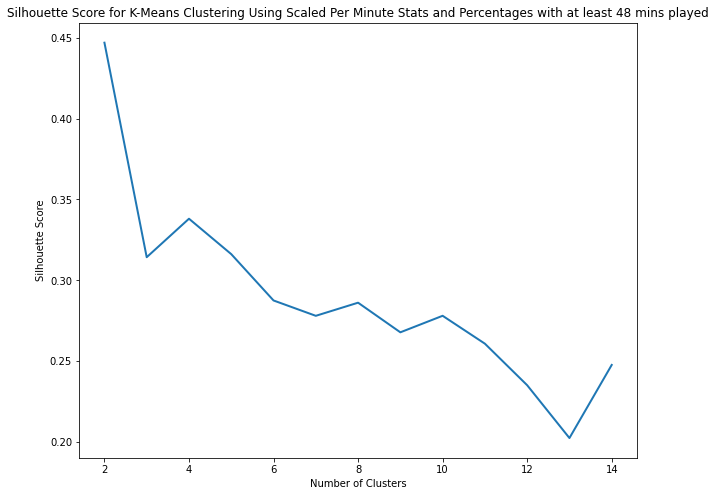

In [ ]:
# adapted from https://www.data4v.com/tutorial-k-means-clustering-on-spark/
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


#KMeans_=KMeans(featuresCol='avg_features', k=9)

#KMeans_fit=KMeans_.fit(assembled_data)

#KMeans_transform=KMeans_fit.transform(assembled_data) 

#This is if you want to test a range of Ks
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='avg_features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')
for K in range(2,15):
    print(K)
    KMeans_=KMeans(featuresCol='avg_features', k=K)

    KMeans_fit=KMeans_.fit(assembled_data)

    KMeans_transform=KMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

    print(f"evaluation score : {evaluation_score}")
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,15),silhouette_scores,linewidth=2)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
plt.title("Silhouette Score for K-Means Clustering Using Scaled Per Minute Stats and Percentages with at least 48 mins played")
plt.savefig("Sillhouette_permin_48mins_scaled")


In [ ]:
KMeans_transform.filter(KMeans_transform.prediction == 2).take(20)